In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.special import inv_boxcox

In [2]:
df = pd.read_csv('Car-Data.csv')

In [3]:
df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.shape

(301, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [6]:
df.describe(include='number')

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [7]:
df['Owner'].unique()

array([0, 1, 3])

In [8]:
df.describe(include='object')

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,301,301,301,301
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,195,261


In [9]:
df['Car_Name'].nunique()

98

In [10]:
df.drop('Car_Name', axis=1, inplace=True)

In [11]:
df.insert(0, "Age", df["Year"].max() + 1 - df["Year"])
df.drop('Year', axis=1, inplace=True)
df.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,5,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,6,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,8,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,5,4.60,6.87,42450,Diesel,Dealer,Manual,0


['Age' 'Selling_Price' 'Present_Price' 'Kms_Driven' 'Owner' 'Fuel_Type'
 'Seller_Type' 'Transmission']


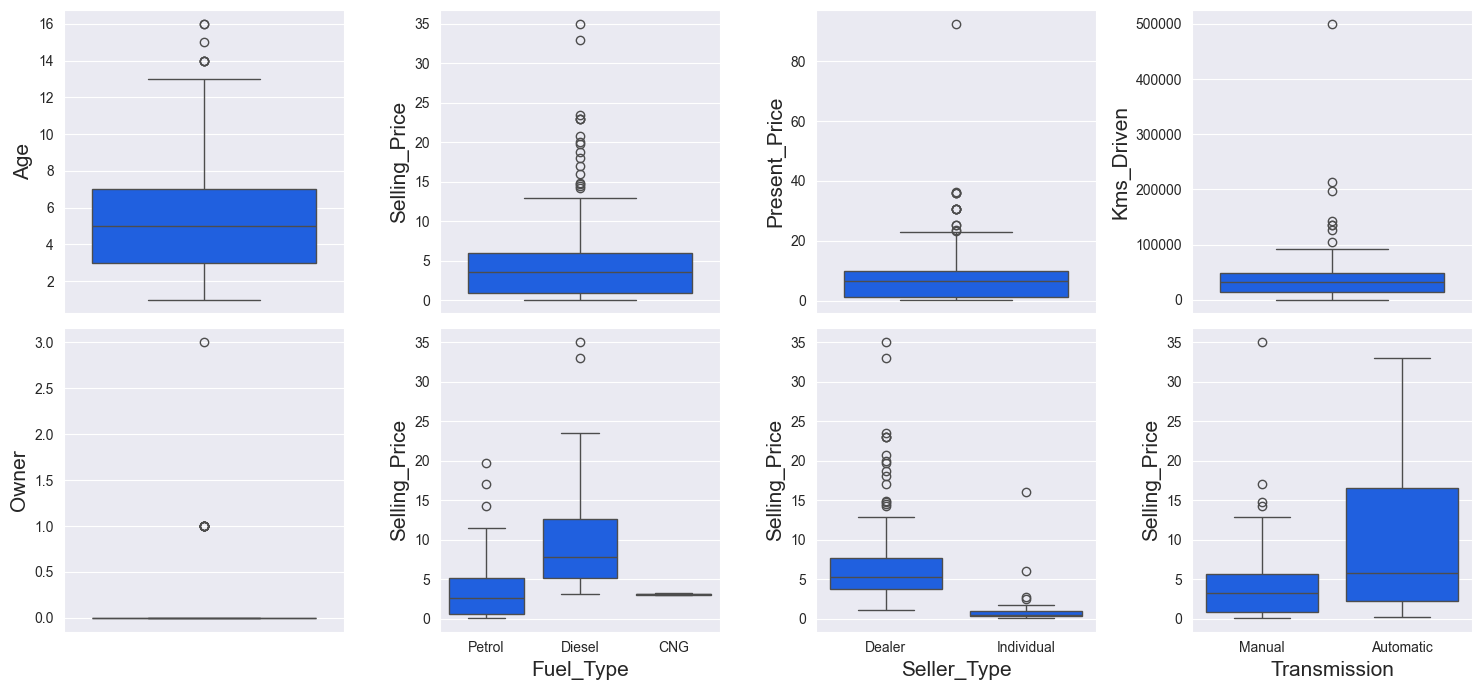

In [12]:
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values, 
                              df.select_dtypes(include='object').columns.values])

print(OrderedCols)

fig, ax = plt.subplots(2, 4, figsize=(15,7),dpi=100)

for i, col in enumerate(OrderedCols):
    x = i // 4
    y = i % 4
    if i < 5:
        sns.boxplot(data=df, y=col, ax=ax[x,y])
        ax[x,y].yaxis.label.set_size(15)
    else:
        sns.boxplot(data=df, x=col, y='Selling_Price', ax=ax[x,y])
        ax[x,y].xaxis.label.set_size(15)
        ax[x,y].yaxis.label.set_size(15)

plt.tight_layout()    
plt.show()

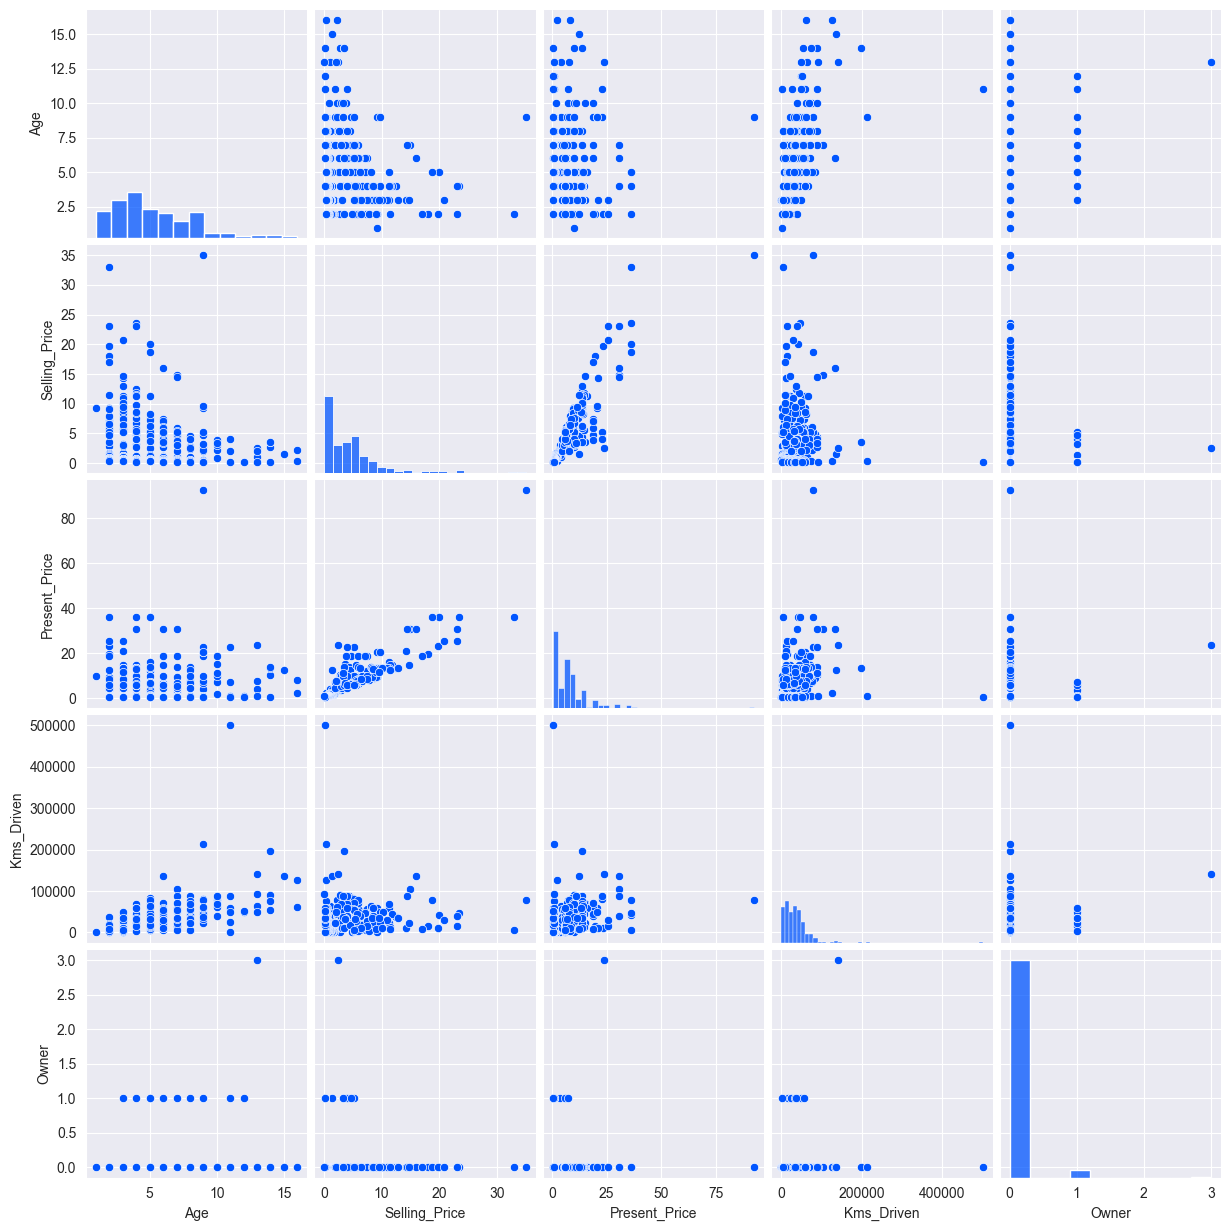

In [13]:
sns.pairplot(df)

In [14]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Age,Selling_Price,Present_Price,Kms_Driven,Owner
Age,1.000000,-0.236141,0.047584,0.524342,0.182104
Selling_Price,-0.236141,1.000000,0.878983,0.029187,-0.088344
Present_Price,0.047584,0.878983,1.000000,0.203647,0.008057
Kms_Driven,0.524342,0.029187,0.203647,1.000000,0.089216
Owner,0.182104,-0.088344,0.008057,0.089216,1.000000


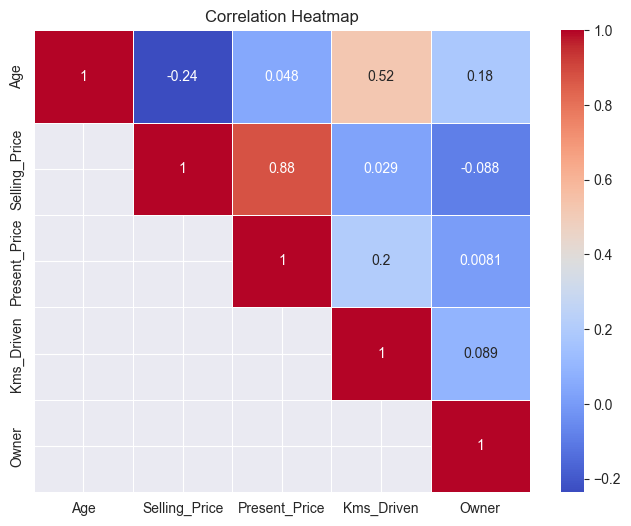

In [15]:
plt.figure(figsize=(8, 6))
# Create a mask for the lower triangle
mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)  # k=-1 keeps the diagonal
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", mask=mask, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
outliers_indexes = []
target = 'Selling_Price'

for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())
        
for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())
    
outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

38 outliers were identified, whose indices are:

[27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 205, 79, 80, 82, 84, 85, 86, 92, 93, 96, 97, 106, 241]


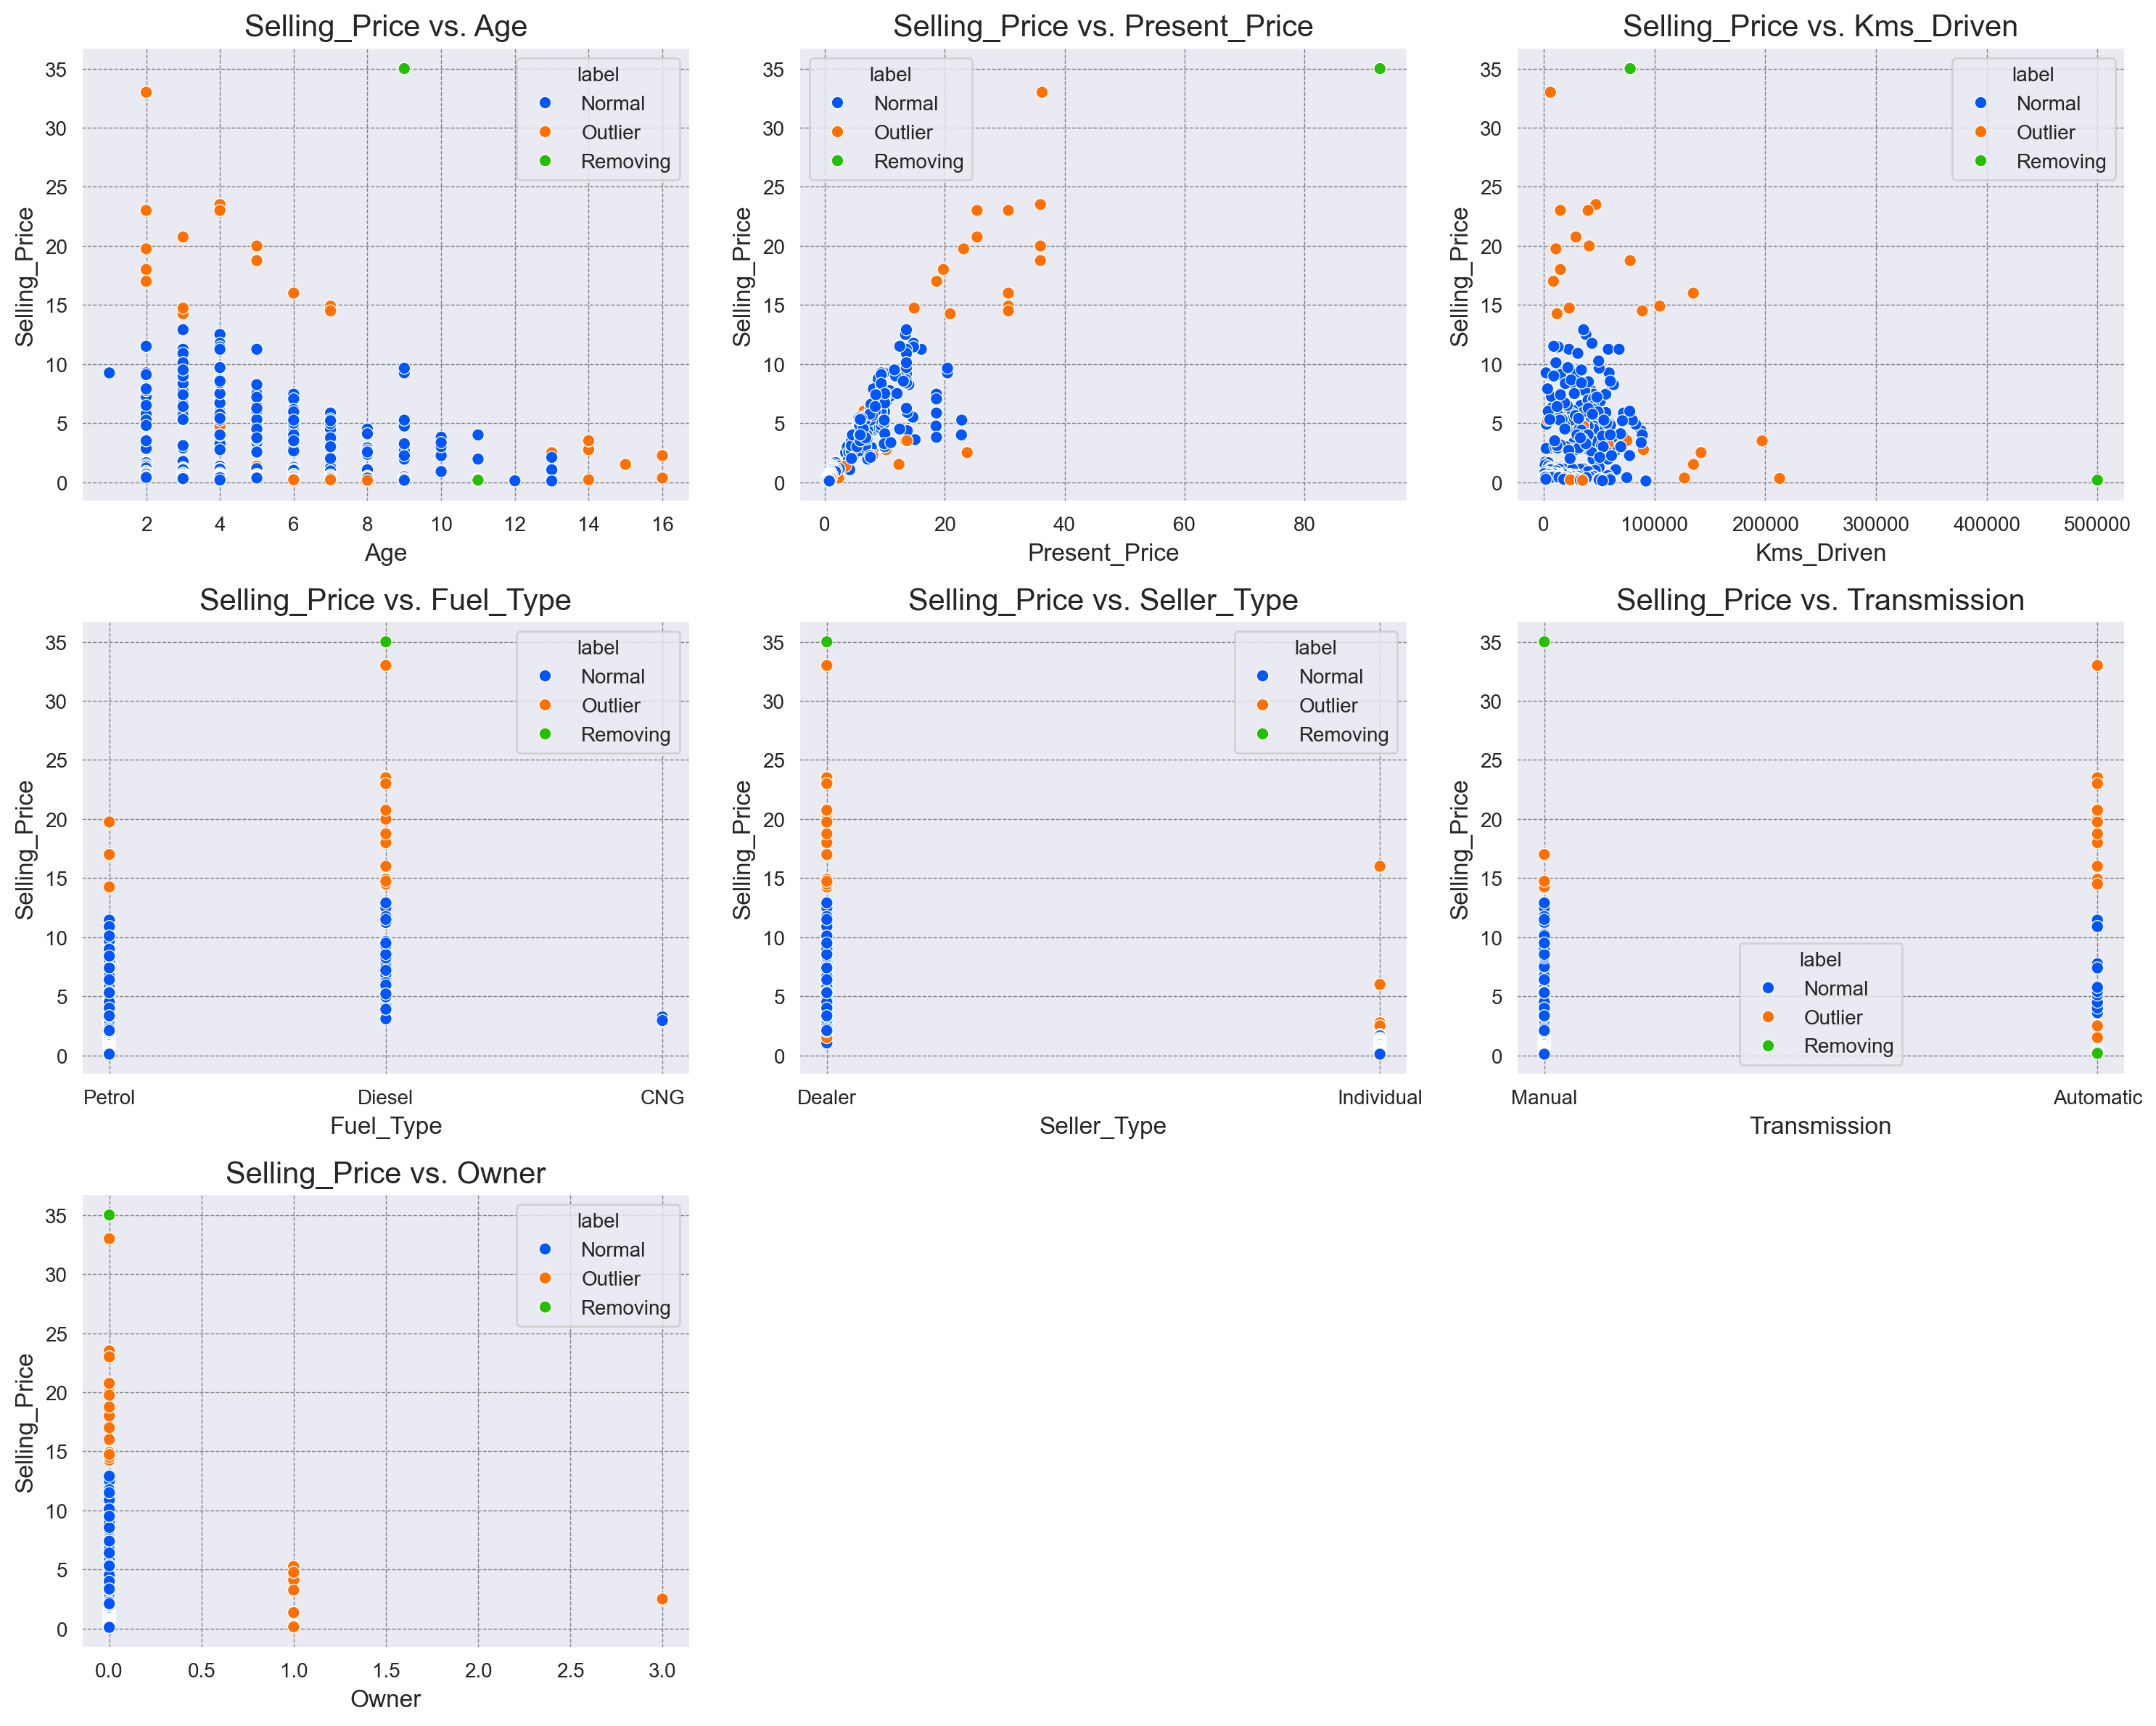

In [22]:
# Outliers Labeling
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'

# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1[target]>33].index)
removing_indexes.extend(df1[df1['Kms_Driven']>400000].index)
df1.loc[removing_indexes,'label'] = 'Removing'

# Plot
target = 'Selling_Price'
features = df.columns.drop(target)
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x = i // 3
    y = i % 3
    sns.scatterplot(data = df1, x = features[i], y = target, hue = 'label', ax = ax[x,y])
    ax[x,y].set_title('{} vs. {}'.format(target, features[i]), size = 15)
    ax[x,y].set_xlabel(features[i], size = 12)
    ax[x,y].set_ylabel(target, size = 12)
    ax[x, y].grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)

ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [23]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[196, 86]

In [24]:
df.isnull().sum()

Age              0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [25]:
df[df.duplicated(keep=False)]

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
15,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
17,3,7.75,10.79,43000,Diesel,Dealer,Manual,0
51,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0
93,4,23.00,30.61,40000,Diesel,Dealer,Automatic,0


In [26]:
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)